# Exploring the v2 runs

To investigate:
1. `jim` interpolation prior class -- for now with Gaussian KDE TODO: check with Peter why he did not like this? DONE
2. More generic jim transforms
3. Implement a Gaussian prior distribution

In [26]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import jax
print(jax.devices())

import numpy as np
import matplotlib.pyplot as plt
from jax import random
key = random.key(0)
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde

from jimgw.prior import KDE, Uniform, Composite, Normal

from scipy.stats import norm

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

[CpuDevice(id=0)]


## Interpolation class

Sample from a particular posterior distribution.

In [5]:
# # TODO: unused for now, using a Gaussian KDE is much simpler for now

# def sample_from_histogram(cdf, bin_edges):
#     u = np.random.uniform(0, 1)
#     bin_index = np.searchsorted(cdf, u) 
#     sample = np.random.uniform(bin_edges[bin_index], bin_edges[bin_index + 1])
#     return sample

### Toy version

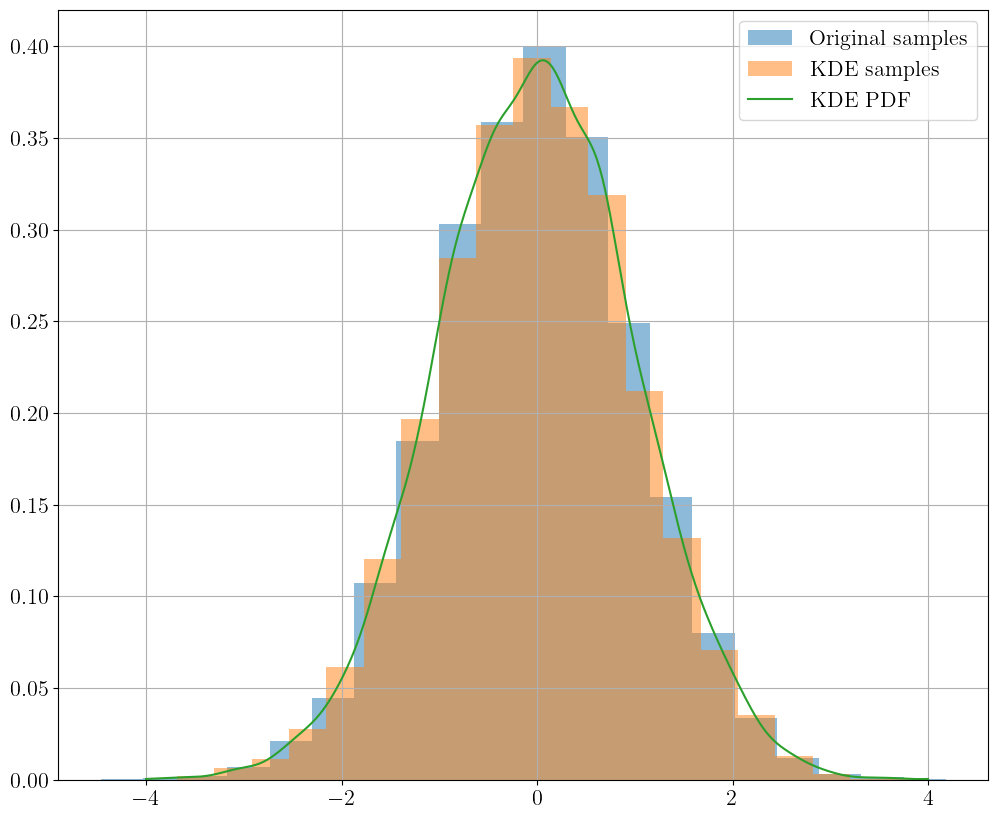

In [6]:
# Get some empirical distribution
N = 10_000
original_samples = np.random.normal(0, 1, N)
hist_counts, bin_edges = np.histogram(original_samples, bins=20, density=True)
cdf = np.cumsum(hist_counts) / np.sum(hist_counts)

kde = gaussian_kde(original_samples)

plt.figure(figsize = (12, 10))
# Original samples
plt.hist(original_samples, bins=20, density=True, alpha=0.5, label='Original samples')
# KDE samples

kde_samples = kde.resample(key, shape=(N,))
plt.hist(kde_samples, bins=20, density=True, alpha=0.5, label='KDE samples')
# KDE PDF
x = np.linspace(-4, 4, 1_000)
plt.plot(x, kde(x), label='KDE PDF')
plt.legend()
plt.show()

### Jim version

(10000,)
(10000,)


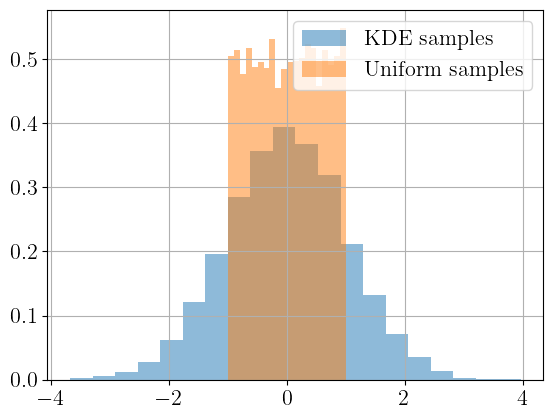

In [7]:
kde = KDE(original_samples, naming = "x")
x = kde.sample(key, N)
print(np.shape(x["x"]))

uniform = Uniform(-1, 1, naming = "y")
y = uniform.sample(key, N)
print(np.shape(y["y"]))

plt.hist(x["x"], bins=20, density=True, alpha=0.5, label='KDE samples')
plt.hist(y["y"], bins=20, density=True, alpha=0.5, label='Uniform samples')
plt.legend()
plt.show()

In [8]:
kde.transforms

{'x': ('x',
  <function jimgw.prior.Prior.__init__.<locals>.make_lambda.<locals>.<lambda>(x)>)}

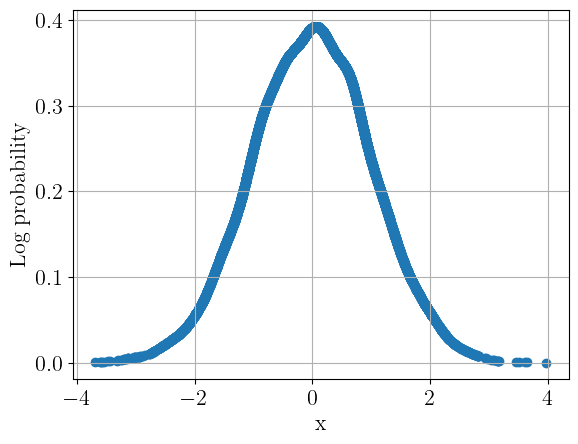

In [9]:
log_prob = kde.log_prob(x)
plt.scatter(x["x"], log_prob)
plt.xlabel("x")
plt.ylabel("Log probability")
plt.show()

## New transforms of the prior

Goal is to sample over H0 and z and then get dL from them and remove H0 and z completely. But need more generic priors for that!

### Old method, old code

In [10]:
Mc_prior = Uniform(1.15, 1.18, naming=['M_c'])
q_prior = Uniform(0.125, 1, naming=['q'],
                        transforms={
                            'q': (
                                'eta',
                                lambda params: params['q'] / (1 + params['q']) ** 2
                                )
                            }
                        )
s1z_prior      = Uniform(-0.05, 0.05, naming=['s1_z'])
s2z_prior      = Uniform(-0.05, 0.05, naming=['s2_z'])
lambda_1_prior = Uniform(0.0, 5000.0, naming=['lambda_1'])
lambda_2_prior = Uniform(0.0, 5000.0, naming=['lambda_2'])
dL_prior       = Uniform(1.0, 60.0, naming=['d_L'])
tc_prior       = Uniform(-0.01, 0.01, naming=['t_c'])
phic_prior     = Uniform(0.0, 2 * jnp.pi, naming=['phase_c'])
cos_iota_prior = Uniform(-1.0, 1.0, naming=["cos_iota"],
                        transforms={
                            "cos_iota": (
                                "iota",
                                lambda params: jnp.arccos(
                                    jnp.arcsin(jnp.sin(params["cos_iota"] / 2 * jnp.pi)) * 2 / jnp.pi
                                ),
                            )
                        },
                        )
psi_prior      = Uniform(0.0, jnp.pi, naming=["psi"])
ra_prior       = Uniform(0.0, 2 * jnp.pi, naming=["ra"])
sin_dec_prior  = Uniform(-1.0, 1.0, naming=["sin_dec"],
    transforms={
        "sin_dec": (
            "dec",
            lambda params: jnp.arcsin(
                jnp.arcsin(jnp.sin(params["sin_dec"] / 2 * jnp.pi)) * 2 / jnp.pi
            ),
        )
    },
)

# Compose the prior
prior_list = [
        Mc_prior,
        q_prior,
        s1z_prior,
        s2z_prior,
        lambda_1_prior,
        lambda_2_prior,
        dL_prior,
        tc_prior,
        phic_prior,
        cos_iota_prior,
        psi_prior,
        ra_prior,
        sin_dec_prior,
]

complete_prior = Composite(prior_list)

In [11]:
test = complete_prior.sample(key, 10)
test = complete_prior.transform(test)
print(test)

{'M_c': Array([1.1604688, 1.1644632, 1.1506162, 1.1659483, 1.1689186, 1.1736095,
       1.1522429, 1.1513568, 1.1606295, 1.151853 ], dtype=float32), 'eta': Array([0.22658175, 0.24979426, 0.20884724, 0.24755038, 0.24871404,
       0.24250416, 0.24869782, 0.23072   , 0.24573229, 0.2499321 ],      dtype=float32), 's1_z': Array([ 0.00540183,  0.0036078 , -0.01556162,  0.00388111, -0.00566529,
        0.04157784,  0.04731196, -0.00399914,  0.01674564,  0.00862916],      dtype=float32), 's2_z': Array([ 0.02191584, -0.00627606,  0.04476557, -0.04524261, -0.01653131,
       -0.02532499, -0.01754572,  0.03939876, -0.01076341, -0.02360198],      dtype=float32), 'lambda_1': Array([ 304.25073, 2635.3694 , 1342.0146 , 4748.508  , 2999.2617 ,
       2143.742  ,  567.13165,   96.07196, 3022.5928 , 1029.554  ],      dtype=float32), 'lambda_2': Array([1827.6721, 2466.2065, 2345.2454, 4477.7627, 2925.214 , 4883.728 ,
       2208.1208, 3681.0208, 3201.1682, 1724.0697], dtype=float32), 'd_L': Array([35.12

### New method, old code

In [12]:
Mc_prior = Uniform(1.15, 1.18, naming=['M_c'])
q_prior = Uniform(0.125, 1, naming=['q'])
s1z_prior      = Uniform(-0.05, 0.05, naming=['s1_z'])
s2z_prior      = Uniform(-0.05, 0.05, naming=['s2_z'])
lambda_1_prior = Uniform(0.0, 5000.0, naming=['lambda_1'])
lambda_2_prior = Uniform(0.0, 5000.0, naming=['lambda_2'])
dL_prior       = Uniform(1.0, 60.0, naming=['d_L'])
tc_prior       = Uniform(-0.01, 0.01, naming=['t_c'])
phic_prior     = Uniform(0.0, 2 * jnp.pi, naming=['phase_c'])
cos_iota_prior = Uniform(-1.0, 1.0, naming=["cos_iota"])
psi_prior      = Uniform(0.0, jnp.pi, naming=["psi"])
ra_prior       = Uniform(0.0, 2 * jnp.pi, naming=["ra"])
sin_dec_prior  = Uniform(-1.0, 1.0, naming=["sin_dec"])

# Compose the prior
prior_list = [
        Mc_prior,
        q_prior,
        s1z_prior,
        s2z_prior,
        lambda_1_prior,
        lambda_2_prior,
        dL_prior,
        tc_prior,
        phic_prior,
        cos_iota_prior,
        psi_prior,
        ra_prior,
        sin_dec_prior,
]

complete_prior = Composite(prior_list)

In [13]:
from jimgw.transforms import Transform, default_functions

transforms = [default_functions["q_to_eta"],
              default_functions["cos_iota_to_iota"],
              default_functions["sin_dec_to_dec"]]

tf = Transform(transforms, ["M_c", "s1_z", "s2_z", "lambda_1", "lambda_2", "d_L", "t_c", "phase_c", "psi", "ra"])

In [14]:
test = complete_prior.sample(key, 10)
test = tf.transform(test)
print(test)

{'eta': Array([0.22658175, 0.24979426, 0.20884724, 0.24755038, 0.24871404,
       0.24250416, 0.24869782, 0.23072   , 0.24573229, 0.2499321 ],      dtype=float32), 'iota': Array([1.2269139 , 0.9267662 , 2.0147183 , 0.35865805, 1.8390708 ,
       1.7793529 , 1.8674034 , 1.8999867 , 1.5101213 , 1.6662244 ],      dtype=float32), 'dec': Array([-0.45985624, -0.11765209, -0.23239669,  0.22257002,  1.1448551 ,
       -0.6614031 , -0.79634196,  0.54623115, -0.29001504, -0.60197717],      dtype=float32), 'M_c': Array([1.1604688, 1.1644632, 1.1506162, 1.1659483, 1.1689186, 1.1736095,
       1.1522429, 1.1513568, 1.1606295, 1.151853 ], dtype=float32), 's1_z': Array([ 0.00540183,  0.0036078 , -0.01556162,  0.00388111, -0.00566529,
        0.04157784,  0.04731196, -0.00399914,  0.01674564,  0.00862916],      dtype=float32), 's2_z': Array([ 0.02191584, -0.00627606,  0.04476557, -0.04524261, -0.01653131,
       -0.02532499, -0.01754572,  0.03939876, -0.01076341, -0.02360198],      dtype=float32), 'la

### New method, new code

In [15]:
Mc_prior = Uniform(1.15, 1.18, naming=['M_c'])
q_prior = Uniform(0.125, 1, naming=['q'])
s1z_prior      = Uniform(-0.05, 0.05, naming=['s1_z'])
s2z_prior      = Uniform(-0.05, 0.05, naming=['s2_z'])
lambda_1_prior = Uniform(0.0, 5000.0, naming=['lambda_1'])
lambda_2_prior = Uniform(0.0, 5000.0, naming=['lambda_2'])
H0_prior       = Uniform(50.0, 80.0, naming=['H_0'])
z_prior        = Uniform(0.009783 - 0.000023, 0.009783 + 0.000023, naming=['z'])
tc_prior       = Uniform(-0.01, 0.01, naming=['t_c'])
phic_prior     = Uniform(0.0, 2 * jnp.pi, naming=['phase_c'])
cos_iota_prior = Uniform(-1.0, 1.0, naming=["cos_iota"])
psi_prior      = Uniform(0.0, jnp.pi, naming=["psi"])
ra_prior       = Uniform(0.0, 2 * jnp.pi, naming=["ra"])
sin_dec_prior  = Uniform(-1.0, 1.0, naming=["sin_dec"])

# Compose the prior
prior_list = [
        Mc_prior,
        q_prior,
        s1z_prior,
        s2z_prior,
        lambda_1_prior,
        lambda_2_prior,
        H0_prior,
        z_prior,
        tc_prior,
        phic_prior,
        cos_iota_prior,
        psi_prior,
        ra_prior,
        sin_dec_prior,
]

complete_prior = Composite(prior_list)

In [16]:
### New method, old code
from jimgw.transforms import Transform, default_functions

transforms = [default_functions["q_to_eta"],
              default_functions["cos_iota_to_iota"],
              default_functions["sin_dec_to_dec"],
              default_functions["H0_z_to_dL"]]

tf = Transform(transforms, ["M_c", "s1_z", "s2_z", "lambda_1", "lambda_2", "t_c", "phase_c", "psi", "ra"])
test = complete_prior.sample(key, 10)
print("test, before transform")
print(test)
print("\n")

test = tf.transform(test)
print("test, after transform")
print(test)

test, before transform
{'M_c': Array([1.1604688, 1.1644632, 1.1506162, 1.1659483, 1.1689186, 1.1736095,
       1.1522429, 1.1513568, 1.1606295, 1.151853 ], dtype=float32), 'q': Array([0.5313227 , 0.94422644, 0.4227556 , 0.8198576 , 0.8661589 ,
       0.7048019 , 0.86537325, 0.56530684, 0.76888573, 0.9675781 ],      dtype=float32), 's1_z': Array([ 0.00540183,  0.0036078 , -0.01556162,  0.00388111, -0.00566529,
        0.04157784,  0.04731196, -0.00399914,  0.01674564,  0.00862916],      dtype=float32), 's2_z': Array([ 0.02191584, -0.00627606,  0.04476557, -0.04524261, -0.01653131,
       -0.02532499, -0.01754572,  0.03939876, -0.01076341, -0.02360198],      dtype=float32), 'lambda_1': Array([ 304.25073, 2635.3694 , 1342.0146 , 4748.508  , 2999.2617 ,
       2143.742  ,  567.13165,   96.07196, 3022.5928 , 1029.554  ],      dtype=float32), 'lambda_2': Array([1827.6721, 2466.2065, 2345.2454, 4477.7627, 2925.214 , 4883.728 ,
       2208.1208, 3681.0208, 3201.1682, 1724.0697], dtype=float32)

## Test the Normal distribution

Sampling

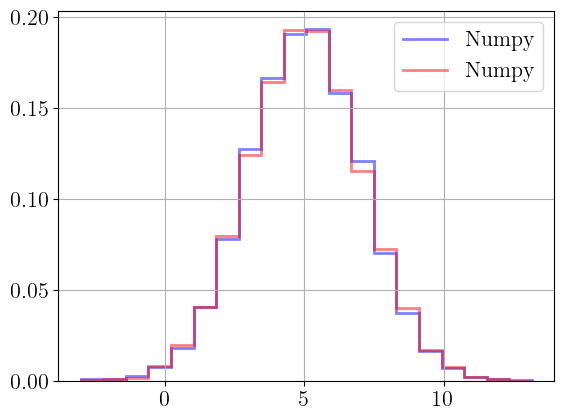

In [25]:
mean = 5.0
std = 2.0
N = 10_000

# Jax (jim)
normal = Normal(mean, std, naming = "x")
key = random.PRNGKey(0)
samples_jax = normal.sample(key, N)
samples_jax

# Numpy:
samples_np = np.random.normal(mean, std, N)

hist_np, edges = np.histogram(samples_np, bins=20, density=True)
hist_jax, _ = np.histogram(samples_jax["x"], bins=edges, density=True)

plt.stairs(hist_np, edges, label="Numpy", alpha=0.5, color="blue", linewidth = 2)
plt.stairs(hist_jax, edges, label="Numpy", alpha=0.5, color="red", linewidth = 2)
plt.legend()
plt.show()

PDF

{'x': array([-5.00000000e+00, -4.97997998e+00, -4.95995996e+00, -4.93993994e+00,
       -4.91991992e+00, -4.89989990e+00, -4.87987988e+00, -4.85985986e+00,
       -4.83983984e+00, -4.81981982e+00, -4.79979980e+00, -4.77977978e+00,
       -4.75975976e+00, -4.73973974e+00, -4.71971972e+00, -4.69969970e+00,
       -4.67967968e+00, -4.65965966e+00, -4.63963964e+00, -4.61961962e+00,
       -4.59959960e+00, -4.57957958e+00, -4.55955956e+00, -4.53953954e+00,
       -4.51951952e+00, -4.49949950e+00, -4.47947948e+00, -4.45945946e+00,
       -4.43943944e+00, -4.41941942e+00, -4.39939940e+00, -4.37937938e+00,
       -4.35935936e+00, -4.33933934e+00, -4.31931932e+00, -4.29929930e+00,
       -4.27927928e+00, -4.25925926e+00, -4.23923924e+00, -4.21921922e+00,
       -4.19919920e+00, -4.17917918e+00, -4.15915916e+00, -4.13913914e+00,
       -4.11911912e+00, -4.09909910e+00, -4.07907908e+00, -4.05905906e+00,
       -4.03903904e+00, -4.01901902e+00, -3.99899900e+00, -3.97897898e+00,
       -3.95895896e

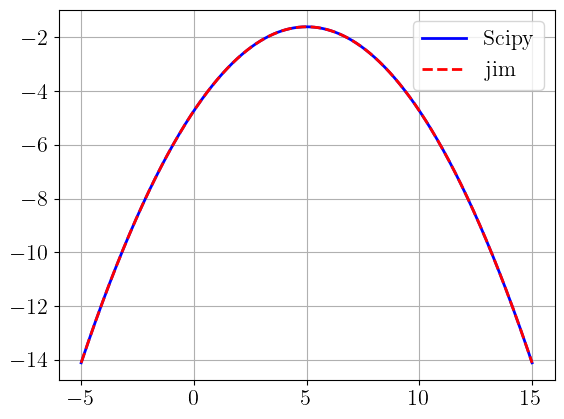

In [35]:
N = 1_000
xmin = mean - 5 * std
xmax = mean + 5 * std
x_array = np.linspace(xmin, xmax, N)

x_array_named = {"x": x_array}

log_pdf_scipy = norm.logpdf(x_array, mean, std)
log_pdf_jax = normal.log_prob(x_array_named)

# print(log_pdf_jax)

plt.plot(x_array, log_pdf_scipy, label="Scipy", linewidth = 2, color = "blue")
plt.plot(x_array, log_pdf_jax, label="jim", linewidth = 2, linestyle = "--", color = "red")
plt.legend()
plt.show()